# 深度學習HW1-自動光學檢查 AOI
### 授課老師 邵皓強

## 安裝環境與環境建置

- Google CoLab
- Python3 GPU
- Pytroch

## 資料準備

### 連動 google drive



In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from sklearn.manifold import TSNE

%matplotlib inline

In [39]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models import vit_b_16, ViT_B_16_Weights
from torchvision.models import vit_l_32, ViT_L_32_Weights
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.13.1+cu117
Torchvision Version:  0.14.1+cu117


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Unzip aoi.zip to cloud environment

In [4]:
cloud_path = r'D:\CHOU\113-1_DL_aoi_classification'
zip_path = r'D:\CHOU\113-1_DL_aoi_classification\aoi.zip'
to_path = '/_temp'

In [5]:
from zipfile import ZipFile

def unzip(paths, to_path):
  """paths: list, to_path"""
  for path in paths:
    if path.endswith('.zip'):
      with ZipFile(path, 'r') as zipObj:
        zipObj.extractall(to_path)
        childs = ['{}/{}'.format(to_path, file_name) for file_name in zipObj.namelist()]
        unzip(childs, to_path)

unzip([zip_path], to_path)

### 訓練資料

In [6]:
df = pd.read_csv('{}/{}'.format(to_path, 'train.csv'))
df.head()

,ID,Label
0,train_00000.png,0
1,train_00001.png,1
2,train_00002.png,1
3,train_00003.png,5
4,train_00004.png,5


### 客製化 AOI 資料集



In [7]:
class aoiDataset(Dataset):
    def __init__(self, root, X, y, transform):
        ##############################################
        ### Initialize paths, transforms, and so on
        ### data list -> DataFrame ID, Label
        ##############################################
        self.transform = transform
        #
        # load image path and annotations
        self.imgs = X
        self.imgs = [ '{}/{}'.format(root, img) for img in self.imgs ]
        self.lbls = y
        assert len(self.imgs) == len(self.lbls), 'mismatched length!'
        print ('Total data split: {}'.format(len(self.imgs)))

    def __getitem__(self, index):
        ##############################################
        # 1. Read from file (using numpy.fromfile, PIL.Image.open)
        # 2. Preprocess the data (torchvision.Transform).
        # 3. Return the data (e.g. image and label)
        ##############################################
        imgpath = self.imgs[index]
        img = Image.open(imgpath).convert('RGB')
        lbl = int(self.lbls[index])
        if self.transform is not None:
            img = self.transform(img)
        return img, lbl

    def __len__(self):
        ##############################################
        ### Indicate the total size of the dataset
        ##############################################
        return len(self.imgs)



### 訓練模型主程式

>參考來源： https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

In [8]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [40]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet50
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "resnet152":
        """ Resnet152
        """
        model_ft = models.resnet152(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    elif model_name == 'vitb16':
        weights = ViT_B_16_Weights.DEFAULT
        model_ft = vit_b_16(weights=weights)
        model_ft.heads[0] = nn.Linear(model_ft.heads[0].in_features, num_classes)
        input_size = 224

    elif model_name == 'vitl32':
        weights = ViT_L_32_Weights
        model_ft = vit_l_32(weights=weights)
        model_ft.heads[0] = nn.Linear(model_ft.heads[0].in_features, num_classes)
        input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [41]:
#
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    history = {
        'loss_val': [],
        'loss_train': [],
        'acc_val': [],
        'acc_train': [],
    }

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                history['acc_val'].append(epoch_acc)
                history['loss_val'].append(epoch_loss)
            else:
                history['acc_train'].append(epoch_acc)
                history['loss_train'].append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

Model setting

In [42]:
# Top level data directory. Here we assume the format of the directory conforms
# Models to choose from [resnet50, resnet152, alexnet, vgg, squeezenet, densenet, inception, vitb16, vitl32]
model_name = "vitl32"

# Number of classes in the dataset
num_classes = 6

# Batch size for training (change depending on how much memory you have)
batch_size = 16

# Number of epochs to train for
num_epochs = 20

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

In [43]:
model, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=False)

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_L_32_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_L_32_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_l_32-c7638314.pth" to C:\Users\USER/.cache\torch\hub\checkpoints\vit_l_32-c7638314.pth
100.0%


### 影像預處理

In [47]:
data_transforms = {
    'train': transforms.Compose([
                transforms.RandomResizedCrop(input_size),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225]),
                ]),
    'val': transforms.Compose([
                    transforms.Resize((input_size, input_size)),
                    transforms.CenterCrop(input_size),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225]),
                    ])
}

### Training, Validation and Testing sets.

In [48]:
from sklearn.model_selection import train_test_split

X = np.array(df['ID'])
y = np.array(df['Label'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.12, random_state=100)

In [49]:
# create train/val datasets
root = '{}/{}'.format(to_path, 'train_images')

trainset = aoiDataset(root=root,
                      X=X_train, y=y_train,
                      transform=data_transforms['train'])
valset = aoiDataset(root=root,
                      X=X_test, y=y_test,
                      transform=data_transforms['val'])

# create train/val loaders
train_loader = DataLoader(dataset=trainset,
                          batch_size=16,
                          shuffle=True)

val_loader = DataLoader(dataset=valset,
                        batch_size=16,
                        shuffle=False)

Total data split: 2224
Total data split: 304


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


    3     0     3     1


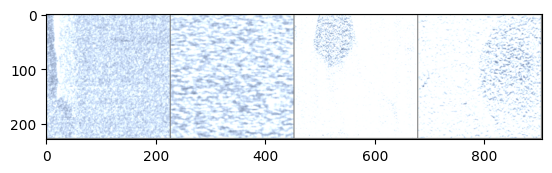

In [50]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(train_loader)
images, labels = next(dataiter)

## 檢視資料
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# # print labels
print(' '.join('%5d' % labels[j] for j in range(4)))

https://towardsdatascience.com/how-to-train-an-image-classifier-in-pytorch-and-use-it-to-perform-basic-inference-on-single-images-99465a1e9bf5

have to freeze the pre-trained layers, so we don’t backprop through them during training.

In [51]:
# Send the model to GPU
model = model.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.

params_to_update = model.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

criterion = nn.CrossEntropyLoss()

Params to learn:
	 class_token
	 conv_proj.weight
	 conv_proj.bias
	 encoder.pos_embedding
	 encoder.layers.encoder_layer_0.ln_1.weight
	 encoder.layers.encoder_layer_0.ln_1.bias
	 encoder.layers.encoder_layer_0.self_attention.in_proj_weight
	 encoder.layers.encoder_layer_0.self_attention.in_proj_bias
	 encoder.layers.encoder_layer_0.self_attention.out_proj.weight
	 encoder.layers.encoder_layer_0.self_attention.out_proj.bias
	 encoder.layers.encoder_layer_0.ln_2.weight
	 encoder.layers.encoder_layer_0.ln_2.bias
	 encoder.layers.encoder_layer_0.mlp.0.weight
	 encoder.layers.encoder_layer_0.mlp.0.bias
	 encoder.layers.encoder_layer_0.mlp.3.weight
	 encoder.layers.encoder_layer_0.mlp.3.bias
	 encoder.layers.encoder_layer_1.ln_1.weight
	 encoder.layers.encoder_layer_1.ln_1.bias
	 encoder.layers.encoder_layer_1.self_attention.in_proj_weight
	 encoder.layers.encoder_layer_1.self_attention.in_proj_bias
	 encoder.layers.encoder_layer_1.self_attention.out_proj.weight
	 encoder.layers.encoder_la

In [52]:
dataloaders = {
    'train': train_loader,
    'val': val_loader
}

model, history = train_model(model, dataloaders, criterion, optimizer, num_epochs=num_epochs, is_inception=False)

Epoch 0/19
----------
train Loss: 0.4742 Acc: 0.8359
val Loss: 0.1389 Acc: 0.9638

Epoch 1/19
----------
train Loss: 0.1815 Acc: 0.9456
val Loss: 0.1084 Acc: 0.9671

Epoch 2/19
----------
train Loss: 0.1552 Acc: 0.9546
val Loss: 0.1550 Acc: 0.9474

Epoch 3/19
----------
train Loss: 0.1144 Acc: 0.9654
val Loss: 0.0876 Acc: 0.9671

Epoch 4/19
----------
train Loss: 0.1373 Acc: 0.9546
val Loss: 0.0947 Acc: 0.9704

Epoch 5/19
----------
train Loss: 0.1059 Acc: 0.9708
val Loss: 0.0730 Acc: 0.9836

Epoch 6/19
----------
train Loss: 0.0888 Acc: 0.9753
val Loss: 0.0716 Acc: 0.9836

Epoch 7/19
----------
train Loss: 0.0908 Acc: 0.9667
val Loss: 0.0808 Acc: 0.9770

Epoch 8/19
----------
train Loss: 0.0892 Acc: 0.9726
val Loss: 0.0733 Acc: 0.9836

Epoch 9/19
----------
train Loss: 0.0836 Acc: 0.9730
val Loss: 0.0711 Acc: 0.9803

Epoch 10/19
----------
train Loss: 0.0817 Acc: 0.9699
val Loss: 0.0792 Acc: 0.9704

Epoch 11/19
----------
train Loss: 0.0578 Acc: 0.9825
val Loss: 0.1040 Acc: 0.9638

Ep

In [53]:
output_path = '{}/{}'.format(cloud_path, 'aoi_{}_20241006.pth'.format(model_name))
# torch.save colab 會有 error output, 不需要理會
torch.save(model, output_path)

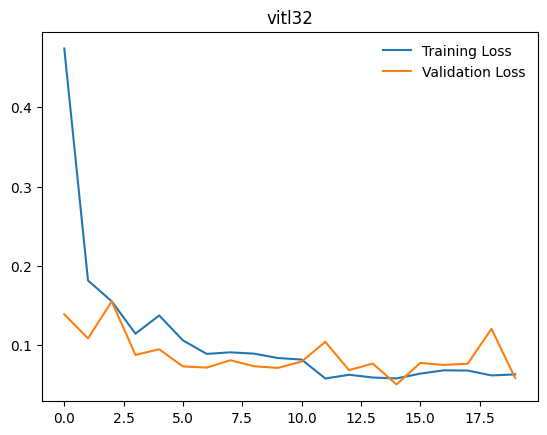

In [54]:
plt.title(model_name)
plt.plot(history['loss_train'], label='Training Loss')
plt.plot(history['loss_val'], label='Validation Loss')
# plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

## 驗證 Testing Set

In [55]:
df_test = pd.read_csv('{}/{}'.format(to_path, 'test.csv'))
df_test['Label'] = 0

df_test.head()

,ID,Label
0,test_00000.png,0
1,test_00001.png,0
2,test_00002.png,0
3,test_00003.png,0
4,test_00004.png,0


In [57]:
# load model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# output_path = '{}/{}'.format(to_path, output_path)
output_path = r'D:\CHOU\113-1_DL_aoi_classification\aoi_vitl32_20241006.pth'
model = torch.load(output_path)
model.eval()

VisionTransformer(
  (conv_proj): Conv2d(3, 1024, kernel_size=(32, 32), stride=(32, 32))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=4096, out_features=1024, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
       

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total data split: 10142


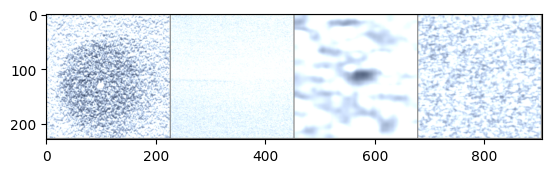

In [58]:
# create train/val datasets
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

test_root = '{}/{}'.format(to_path, 'test_images')


testset = aoiDataset(root=test_root,
                      X=np.array(df_test['ID']), y=np.array(df_test['Label']),
                      transform=data_transforms['val'])

test_loader = DataLoader(dataset=testset,
                        batch_size=8,
                        shuffle=False,)


dataiter = iter(test_loader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images[:4]))

In [59]:
test_output = []

for inputs, labels in test_loader:
    outputs = model(inputs.to(device))
    _, predicted = torch.max(outputs, 1)
    test_output += predicted.tolist()

In [35]:
df_output = df_test.copy()
df_output['Label'] = test_output
df_output.head(10)

,ID,Label
0,test_00000.png,1
1,test_00001.png,2
2,test_00002.png,5
3,test_00003.png,0
4,test_00004.png,2
5,test_00005.png,5
6,test_00006.png,5
7,test_00007.png,5
8,test_00008.png,0
9,test_00009.png,2


In [60]:
df_output.to_csv( '{}/{}'.format(cloud_path, 'aoi_{}.csv'.format(model_name)), index=0)

### Plotting t-SNE for training and testing set 

In [61]:
def extract_features(data_loader, model, device):
    model.eval()  
    features = []
    labels = []
    with torch.no_grad():
        for images, label in data_loader:
            images = images.to(device)
            output = model(images)  
            features.append(output.cpu().numpy())  
            labels.extend(label.cpu().numpy())
    return np.concatenate(features), np.array(labels)


def extract_features_without_labels(data_loader, model, device):
    model.eval()  
    features = []
    with torch.no_grad():
        for images in data_loader:
            images = images.to(device)
            output = model(images)  
            features.append(output.cpu().numpy())
    return np.concatenate(features)


def plot_tsne_with_predictions(model, data_loader, device, title, random_state=42):
    model.eval() 
    features = []
    predictions = []
    with torch.no_grad():
        for images, _ in data_loader: 
            images = images.to(device)
            outputs = model(images)
            features.append(outputs.cpu().numpy()) 
            _, predicted = torch.max(outputs, 1)  
            predictions.extend(predicted.cpu().tolist())

    tsne = TSNE(n_components=2, random_state=random_state)
    tsne_results = tsne.fit_transform(np.concatenate(features))

    plt.figure(figsize=(8, 6))

    unique_labels = np.unique(predictions)

    for label in unique_labels:
        label_mask = np.array(predictions) == label
        plt.scatter(tsne_results[label_mask, 0], tsne_results[label_mask, 1], label=f'Class {label}', alpha=0.7)

    plt.title(title)
    plt.xlabel("1st dimension")
    plt.ylabel("2nd dimension")
    plt.grid(True)

    plt.legend(loc='best')
    plt.show()

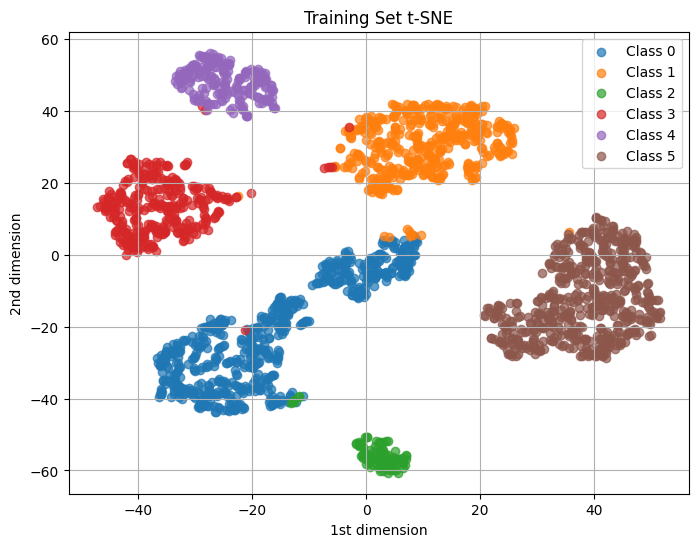

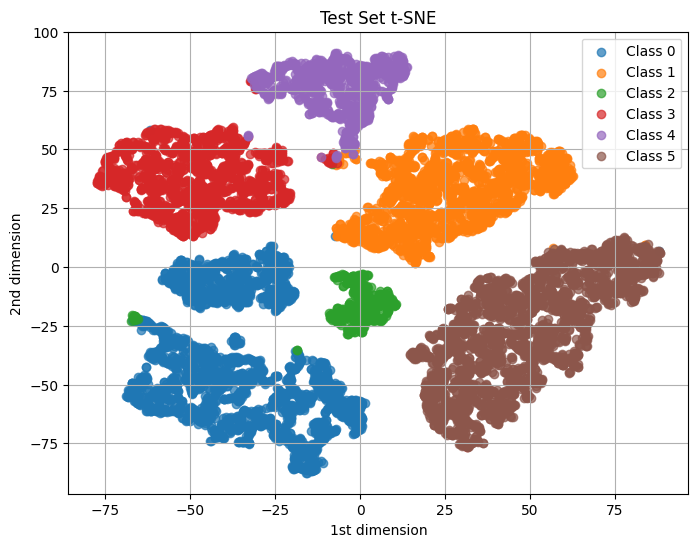

In [62]:
train_features, train_labels = extract_features(train_loader, model, device)

plot_tsne_with_predictions(model, train_loader, device, "Training Set t-SNE")

plot_tsne_with_predictions(model, test_loader, device, "Test Set t-SNE")